In [1]:
import sys
if "/Users/raymond/code/FinalProject563" not in sys.path:
    sys.path.append("/Users/raymond/code/FinalProject563")

import time
import torch
import random
import numpy as np
import pandas

import connect_four
import mcts
import connect_net
import connect_plot

In [2]:
boards = np.load("/Users/raymond/code/FinalProject563/data/move8_boards.npy")
winners = np.load("/Users/raymond/code/FinalProject563/data/move8_winner.npy")

In [3]:
total_num = len(boards)
train_num = int(total_num * 0.8)
val_num = int(total_num * 0.1)
test_num = total_num - train_num - val_num
print(total_num, train_num, val_num, test_num)

shuffled_indexes = list(range(total_num))
random.shuffle(shuffled_indexes)

67557 54045 6755 6757


In [4]:
train_vals = torch.Tensor(boards[shuffled_indexes[:train_num]]).unsqueeze(1)
valid_vals = torch.Tensor(boards[shuffled_indexes[train_num:train_num+val_num]]).unsqueeze(1)
test_vals = torch.Tensor(boards[shuffled_indexes[train_num+val_num:]]).unsqueeze(1)

train_targ = torch.Tensor(winners[shuffled_indexes[:train_num]])
valid_targ = torch.Tensor(winners[shuffled_indexes[train_num:train_num+val_num]])
test_targ = torch.Tensor(winners[shuffled_indexes[train_num+val_num:]])
print(len(train_vals), len(valid_vals), len(test_vals))

54045 6755 6757


In [11]:
nnet = connect_net.ConnectNet()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss(reduction="sum")
l2_lambda = 1

In [9]:
losses_train = []
losses_validation = []

In [12]:
for i in range(250):
    start_time = time.time()
    train_v, proba = nnet(train_vals)
    if torch.isnan(proba).any():
        print("Found nan")
        break
    reg_loss = l2_lambda * sum(p.square().sum() for p in nnet.parameters())
    
    train_loss = loss_fn(train_v, train_targ)
    train_loss = train_loss + reg_loss
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    losses_train.append(train_loss.item())

    valid_v, _ = nnet(valid_vals)
    val_loss = loss_fn(valid_v, valid_targ).item()
    losses_validation.append(val_loss)
    if i % 10 == 0:
        print(f"EPOCH::{i}  LOSS::{val_loss:.4f}  TIME::{time.time() - start_time:.4f}")

EPOCH::0  LOSS::4957.5454  TIME::5.2060
EPOCH::10  LOSS::3336.3789  TIME::6.1440
EPOCH::20  LOSS::3199.1062  TIME::7.0535
EPOCH::30  LOSS::3098.3508  TIME::6.6982
EPOCH::40  LOSS::3091.2559  TIME::7.2018
EPOCH::50  LOSS::3058.0449  TIME::6.0844
EPOCH::60  LOSS::3011.8040  TIME::5.5465
EPOCH::70  LOSS::2966.3132  TIME::5.2714
EPOCH::80  LOSS::2907.4143  TIME::5.1027
EPOCH::90  LOSS::2840.1025  TIME::5.2853
EPOCH::100  LOSS::2752.5571  TIME::5.2451
EPOCH::110  LOSS::2628.9048  TIME::5.5380
EPOCH::120  LOSS::2465.1721  TIME::6.2087
EPOCH::130  LOSS::2266.9109  TIME::4.9250
EPOCH::140  LOSS::2171.3687  TIME::5.0793
EPOCH::150  LOSS::2057.5718  TIME::5.0036
EPOCH::160  LOSS::1970.1316  TIME::6.2050
EPOCH::170  LOSS::1882.8688  TIME::5.0485
EPOCH::180  LOSS::1806.1038  TIME::6.3187
EPOCH::190  LOSS::1746.1414  TIME::5.5144
EPOCH::200  LOSS::1721.7915  TIME::5.6605
EPOCH::210  LOSS::1641.9136  TIME::5.2964
EPOCH::220  LOSS::1604.9711  TIME::6.1354
EPOCH::230  LOSS::1574.4945  TIME::6.9536
EPO

<AxesSubplot:>

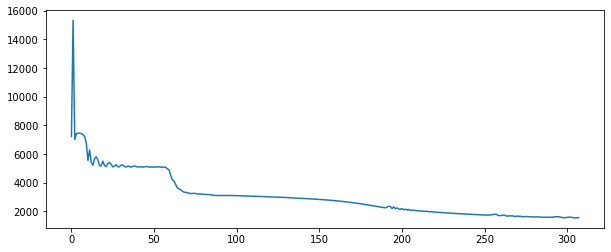

In [13]:
pandas.Series(losses_validation).plot(figsize=(10, 4))

In [14]:
connect_net.save_model(nnet, "../models/pretrain01.model")